In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
df = pd.read_csv('Datasets/airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df['LogPassengers'] = np.log(df['Passengers'])

In [5]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [6]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [7]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [8]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [9]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [10]:
# RNN
i = Input(shape=(T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)
model = Model(i, x)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [13]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 [==============================] - 6s 144ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 2/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0089
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 11/100
4/4 [

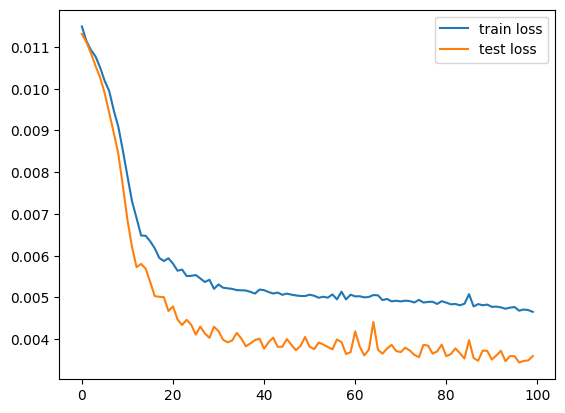

In [14]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [15]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [16]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 16ms/step


In [17]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [18]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [19]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

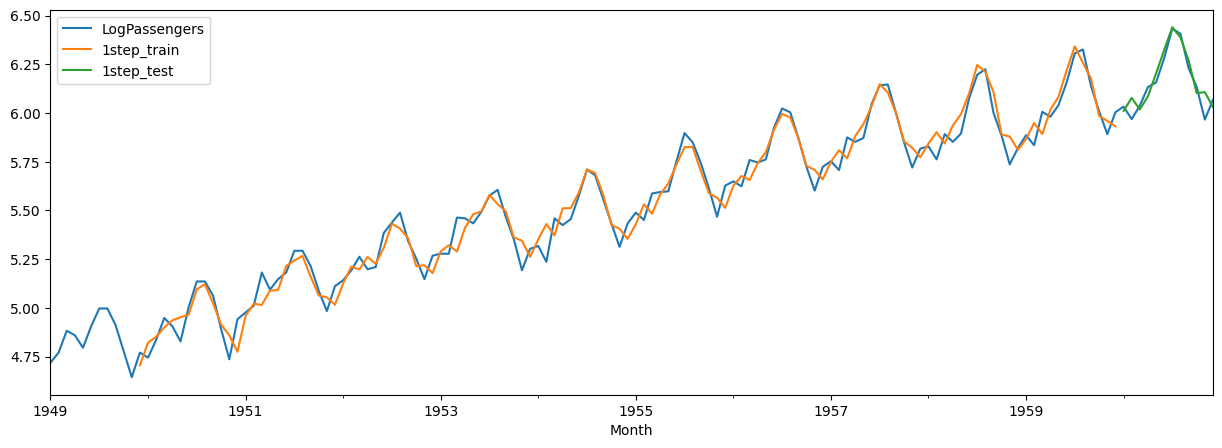

In [20]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [21]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 17ms/step


In [22]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

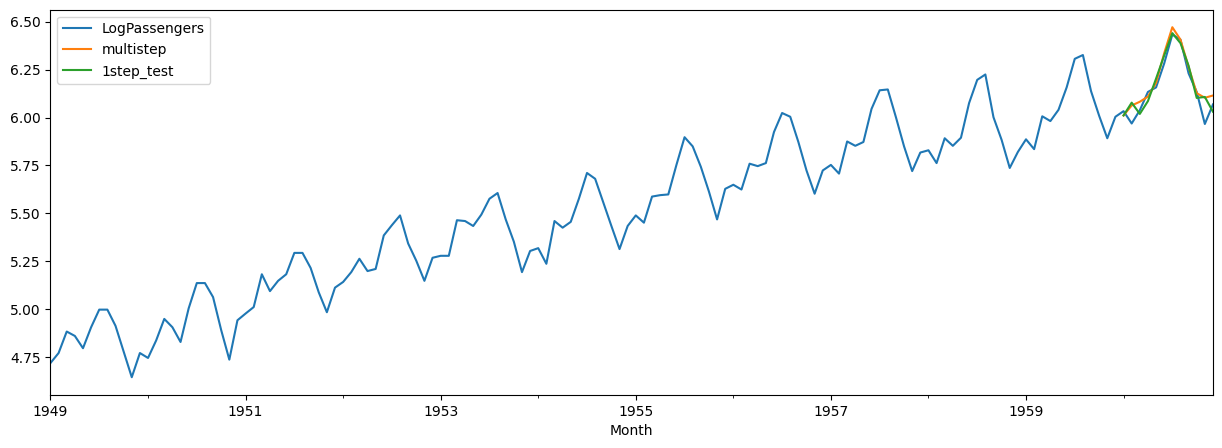

In [23]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [24]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [25]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [26]:
# RNN
i = Input(shape=(Tx, 1))
x = LSTM(24, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [27]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)

In [28]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [29]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300
4/4 [==============================] - 2s 153ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 2/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 3/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 4/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 5/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 6/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 7/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 8/300
4/4 [==============================] - 0s 25ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 9/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 10/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 11/300
4/4 [

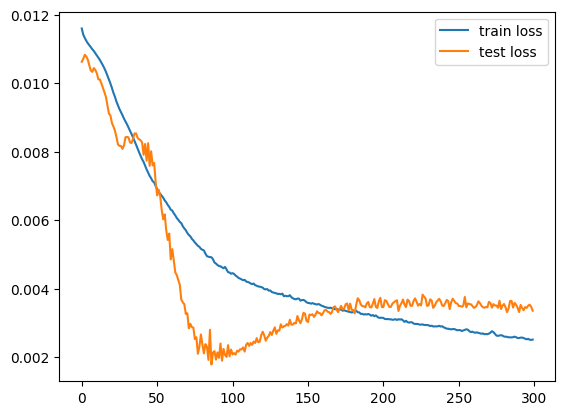

In [30]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [31]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [32]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 31ms/step


In [33]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [34]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [35]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

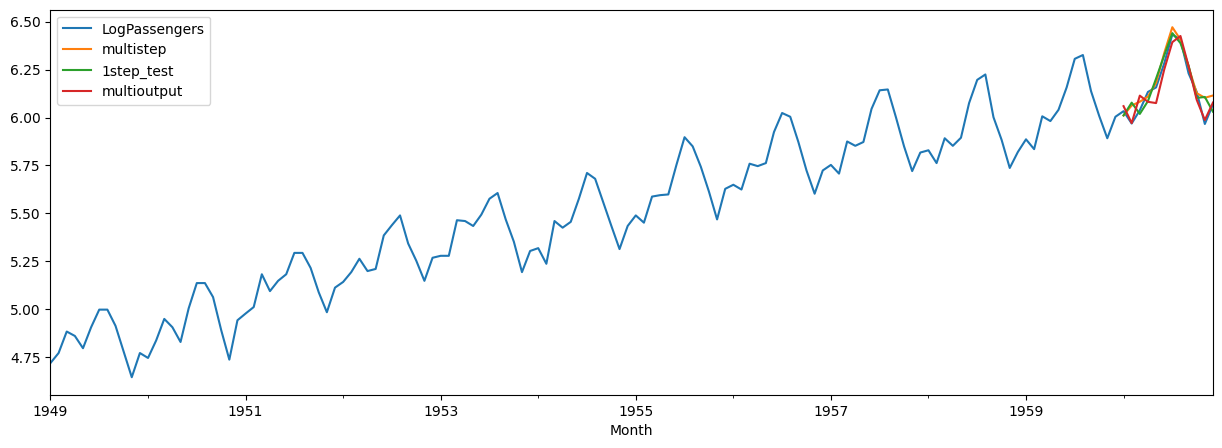

In [36]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [37]:
# RNN multiple LSTM layers
i = Input(shape=(Tx, 1))
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [38]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)

In [39]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [40]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300
4/4 [==============================] - 3s 189ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 2/300
4/4 [==============================] - 0s 29ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 3/300
4/4 [==============================] - 0s 19ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 4/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 5/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 6/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 7/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 8/300
4/4 [==============================] - 0s 24ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 9/300
4/4 [==============================] - 0s 23ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 10/300
4/4 [==============================] - 0s 23ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 11/300
4/4 [

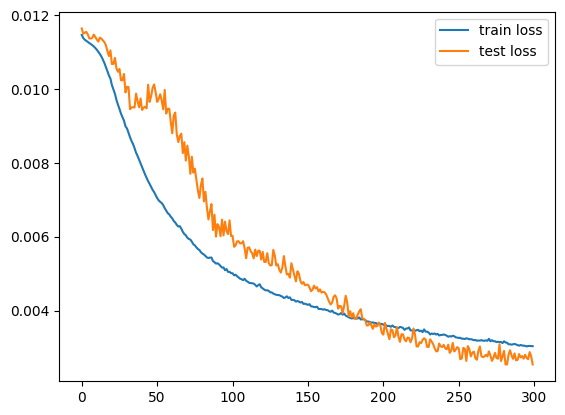

In [41]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [42]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [43]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

1/1 [==============================] - 0s 16ms/step


In [44]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput2'] = last_train + \
  np.cumsum(Ptest)

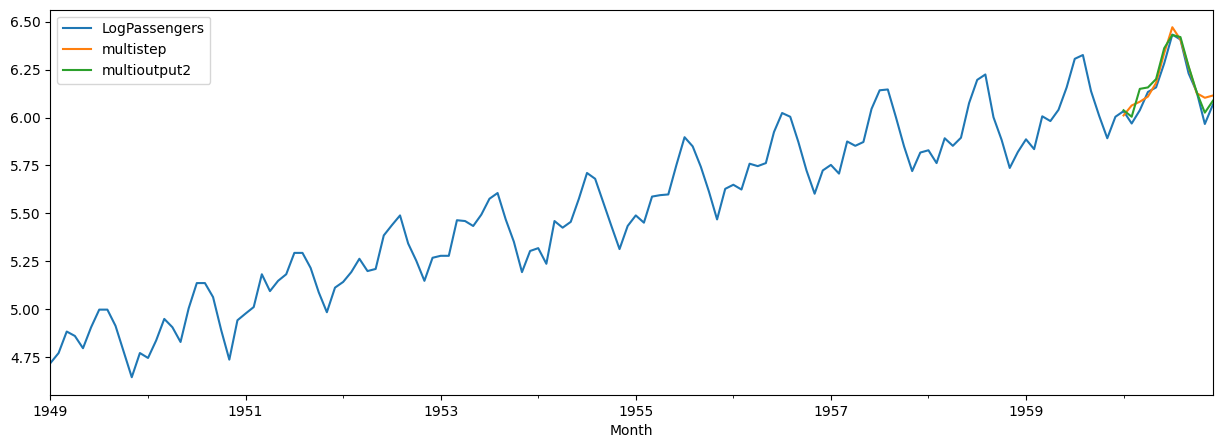

In [45]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', 'multioutput2']
df[cols].plot(figsize=(15, 5));

In [46]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output (2 LSTMs) MAPE:", mape3)

multi-step MAPE: 0.007174030238913065
multi-output MAPE: 0.005904910851437489
multi-output (2 LSTMs) MAPE: 0.005868342017383261


In [ ]:
# Exercise:
# Is the improvement due to global max pooling? Or due to multiple LSTMs layers?
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?